In [155]:
import scipy
from scipy import stats
import numpy as np
import glob, os
import pandas as pd
from itertools import chain
import subprocess
import time
import matplotlib.pyplot as plt

%matplotlib inline

from jupyterthemes import jtplot

jtplot.reset()

porous_dir = '/home/fdutka/porous'

## Parametry układu eksperymentalnego
$W = 33 \, \rm{mm}$, $L = 38 \, \rm{mm}$, $H = 0.5 \, \rm{mm}$, $D = 10^{-5} \, \rm{cm^2/s}$, $k = 4.67 \cdot 10^{-4} \, \rm{cm/s}$

In [29]:
def PeDa(Q,W,h0):
    """
    returns Peclet and Damkohler numbers
    Q in ml/h, W in mm, h0 in mm
    """
    Q = Q*1e3/3600 # transforms into mm^3/s
    D = 1e-3 # [mm^2/s]
    k = 4.67e-3 # [mm/s]

    Pe = Q/(W*D)
    Da = k*h0*W/Q
    return Pe, Da

In [2]:
def nxny(dirin):
    filename = os.path.join(porous_dir, dir1, 'init','phi.dat.00')
    with open(filename,'r') as f:
        l1 = f.readline()
    nx,ny = np.array(l1.split()[:2]).astype(int)
    return nx, ny
    

In [3]:
class phimage:
    
    porous_dir = '/home/fdutka/porous'
    
    def __init__(self, dirname):
        
        filename = os.path.join(porous_dir, dirname, 'init','phi.dat.00')
        with open(filename,'r') as f:
            l1 = f.readline()
        self.nx, self.ny  = np.array(l1.split()[:2]).astype(int)
        self.name = dirname
        self.nproc = len(glob.glob(os.path.join(porous_dir, self.name, 'init','phi.dat.*')))
    
    def phi(self):
        
        lphi = []
        
        for filename in glob.glob(os.path.join(porous_dir, self.name, 'init','phi.dat.*')):
            with open(filename,'r') as f:
                phi = [row.split() for row in f.readlines()[1:]]
            lphi.append(np.array(list(chain(*phi))).astype(float))
        lphi = np.array(lphi).ravel().reshape(self.nx,self.ny)     
    
        return lphi
    
    def phi2(self, filename2):
        
        lphi = []
        
        for i in range(self.nproc):
            filename = os.path.join(porous_dir, self.name, 'data', filename2+'.'+str(i).zfill(2))
            with open(filename,'r') as f:
                phi = [row.split() for row in f.readlines()[1:]]
            lphi.append(np.array(list(chain(*phi))).astype(float))
        lphi = np.array(lphi).ravel().reshape(self.nx,self.ny)     
    
        return lphi
    
    def mean1(self):
        return self.phi().ravel().mean()
    
    def std1(self):
        return self.phi().ravel().std()
    
    def init(self):
        
        filename = os.path.join(porous_dir, self.name, 'init','input.dat')
        with open(filename, 'r') as f:
            data = np.array(f.readlines()[1].split()).astype(float)
        return data
    
    def info(self):
        return f"{'-'*30}\n directory: {self.name} \n mean: {self.mean1()} \n std: {self.std1()} \n{'-'*30}"
    
    def hmax(self):
        filename = os.path.join(porous_dir, self.name, 'init','parms.h')
        hmax = 0
        if os.path.isfile(filename):
            with open(filename,'r') as f:
                data = f.readlines()
                hmax = float([val for val in data if "Maximum Aperture" in val][0].split()[2])
        return hmax
    
    def time_steps(self):
        l1 = np.unique(np.array([os.path.basename(val).split('.')[1] for val in glob.glob(os.path.join(porous_dir, self.name, 'data', 'phi.*'))]))
        l1 = np.sort(l1.astype(int))
        return l1
    
    def BTime(self):
        
        l1 = self.time_steps()
        i = len(l1)-1
        while (self.phi2('phi.'+str(l1[i]).zfill(4))[-1].max() == self.hmax()) and i>0:
            i=i-1
        
        btime = l1[i]+1
        
        return btime

    

In [125]:
# different tape widths
ht  =np.array([100,70,50,30,20,10,0,150,200])
#ht  =np.array([100,10,0])
# initial gypsum height
hg = 500

W = 33 # width of the system
sigma = 5 # assumed deviation standard
h0 = ht+10 # mean initial aperture
cv = np.round(sigma/(h0),5) # coefficient of variance: cv = sigma/ho


In [126]:
folder_names = [f"btimep{i}" for i in range(1,len(h0)+1)] 

In [127]:
df = pd.DataFrame(np.array([ht,h0,cv]).T, columns = ['ht','h0','cv'], index = folder_names)
dfPeDa = pd.DataFrame(list(df.apply(lambda x: list(PeDa(1,33,x.h0/1000)), axis = 1)), index = folder_names, columns = ['Pe','Da'])
df = pd.concat([df,dfPeDa], axis = 1)


In [132]:
df = df.assign(hmax = lambda row: hg+row.ht)
df = df.assign(hmax_sim = lambda row: row.hmax/row.h0)
df = df.assign(cv_sim = lambda row: row.cv*1.175)

df['W'] = 33
df['dt'] = 0.1

In [128]:
df

,ht,h0,cv,Pe,Da
btimep1,100.0,110.0,0.04545,8.417508,0.061028
btimep2,70.0,80.0,0.06250,8.417508,0.044384
btimep3,50.0,60.0,0.08333,8.417508,0.033288
btimep4,30.0,40.0,0.12500,8.417508,0.022192
btimep5,20.0,30.0,0.16667,8.417508,0.016644
btimep6,10.0,20.0,0.25000,8.417508,0.011096
btimep7,0.0,10.0,0.50000,8.417508,0.005548
btimep8,150.0,160.0,0.03125,8.417508,0.088767
btimep9,200.0,210.0,0.02381,8.417508,0.116507


In [9]:
df['cv_sim2'] = df.apply(lambda row: phimage(row.name).std1(), axis = 1)

df['cv_sim2_perc'] = df.apply(lambda row: row.cv_sim2/row.cv, axis = 1)

df['NX'] = df.apply(lambda row: phimage(row.name).nx, axis = 1)
df['dx'] = df.apply(lambda row: row.W/(row.NX*row.h0*1e-3), axis = 1)

dfsim = pd.DataFrame(list(df.apply(lambda row: list(phimage(row.name).init()[[2,3,5]]), axis = 1)), columns = ['Pe_sim','Da_sim', 'dx_sim'], index = df.index)
df = pd.concat([df,dfsim], axis = 1)

In [129]:
df['btime'] = df.apply(lambda row: phimage(row.name).BTime(), axis = 1)

In [130]:
#df = pd.read_csv("btime.csv", index_col = 0)
df

,ht,h0,cv,Pe,Da,btime
btimep1,100.0,110.0,0.04545,8.417508,0.061028,262
btimep2,70.0,80.0,0.06250,8.417508,0.044384,304
btimep3,50.0,60.0,0.08333,8.417508,0.033288,337
btimep4,30.0,40.0,0.12500,8.417508,0.022192,384
btimep5,20.0,30.0,0.16667,8.417508,0.016644,429
btimep6,10.0,20.0,0.25000,8.417508,0.011096,531
btimep7,0.0,10.0,0.50000,8.417508,0.005548,868
btimep8,150.0,160.0,0.03125,8.417508,0.088767,212
btimep9,200.0,210.0,0.02381,8.417508,0.116507,180


In [141]:
df2 = df.sort_values(by = 'cv')[['cv','btime','Da','dt']]

fig2 = plt.figure()
ax = fig2.add_axes([.1,.1,.85, .85])
ax.plot(df2.cv, df2.btime*df2.Da*df2.dt, '-o')
ax.axes.set_xlabel('coefficient of variance')
ax.axes.set_ylabel('breakthrough time (simulation time)')
fig2.tight_layout()
fig2.savefig('Pbtime.eps', dpi = 300)

/home/fdutka/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


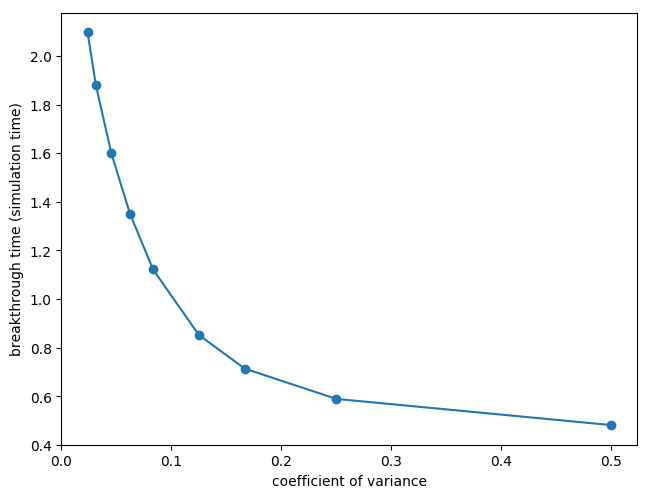

In [135]:
fig2

In [81]:
def finish_check(name):
    """
    checks wether actual timestep of simulation exceeds breakthrough time
    """
    b = phimage(name)
    l1 = b.time_steps()
    print(f"{name}: last = {l1[-1]}, btime = {b.BTime()}")

In [82]:
finish_check('btimep9')

ValueError: cannot reshape array of size 8 into shape (256,256)

In [9]:
finish_check('btimep1')

btimep1: last = 860, btime = 262


In [48]:
finish_check('btimep2')

btimep2: last = 559, btime = 304


In [49]:
finish_check('btimep3')

btimep3: last = 502, btime = 337


In [60]:
finish_check('btimep4')

btimep4: last = 404, btime = 384


In [66]:
finish_check('btimep5')

btimep5: last = 506, btime = 429


In [25]:
finish_check('btimep6')

btimep6: last = 557, btime = 531


In [23]:
finish_check('btimep7')

btimep7: last = 909, btime = 868


In [76]:
finish_check('btimep8')

btimep8: last = 480, btime = 212


In [107]:
finish_check('btimep9')

ValueError: cannot reshape array of size 8 into shape (256,256)

In [14]:
sim = df.iloc[0]
b1 = phimage(sim.name)

NameError: name 'df' is not defined

In [137]:
# calculation of mean values of height for each timetstep in simulation before breakthrough
lm1 = []

for i in range(len(df)):
    sim = df.iloc[i]
    b1 = phimage(sim.name)
    t = b1.time_steps()
    t = t[t<sim.btime]
    
    m1 = [b1.phi2('phi.'+str(ti).zfill(4)).mean() for ti in t]
    lm1.append([t,m1])

/home/fdutka/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


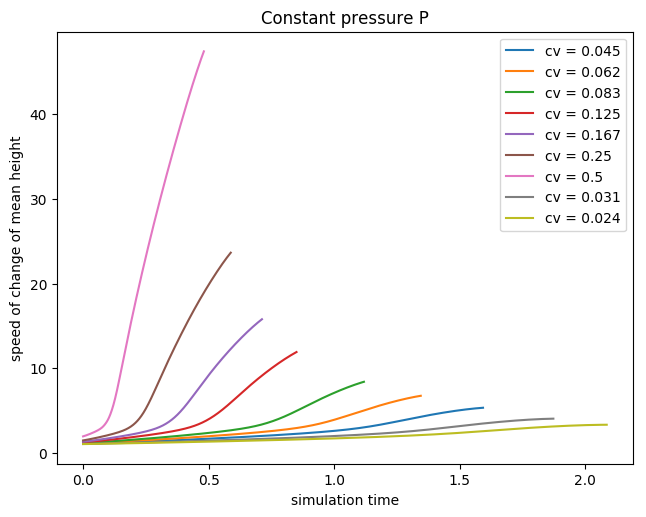

In [138]:
fig = plt.figure()
ax = fig.add_axes([.1,.1,.9, .9])
for i in range(len(df)):
    sim = df.iloc[i]
    m1 = lm1[i]
    ax.plot(m1[0]*sim.Da*sim['dt'], m1[1], '-', label = f"cv = {np.round(sim.cv,3)}")
ax.axes.set_ylabel('speed of change of mean height')
ax.axes.set_xlabel('simulation time')
ax.legend()
ax.axes.set_title('Constant pressure P')
fig.tight_layout()

fig.savefig('Pspeed_mean_h.png', dpi = 300)
fig

In [105]:
# calculation of speed of change of mean value of h
vh = []
for i in range(len(df)):
    tmax = 100
    ntmax = (lm1[i][0]< tmax).astype(int).sum()
    slope, intercept, r_value, p_value, std_err = stats.linregress(lm1[i][0][:ntmax], lm1[i][1][:ntmax])
    print(f"{df.index[i]}:, {slope} \t {intercept}")
    vh.append(slope)
df['vh'] = vh

btimep1:, 0.00756348801356158 	 1.0588220176507535
btimep2:, 0.007409678215399879 	 1.0942317228431684
btimep3:, 0.007314804354126365 	 1.1356874578848992
btimep4:, 0.007219778720086275 	 1.2164654530119492
btimep5:, 0.007199417716259115 	 1.2959542486051714
btimep6:, 0.007081471904189564 	 1.4546262657618425
btimep7:, 0.006615418777328752 	 1.9307781280870768
btimep8:, 0.007847993460412263 	 1.0255215653050525


/home/fdutka/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


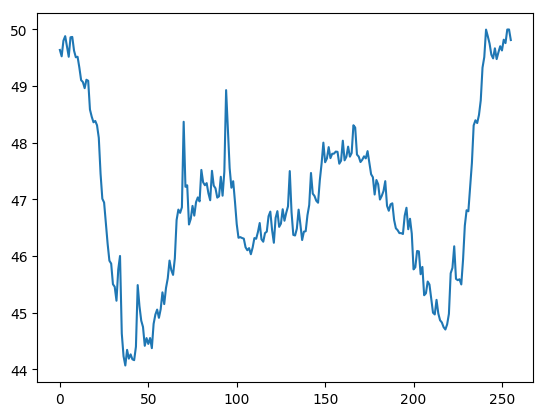

In [157]:
b1 = phimage('btimep7')

phi = b1.phi2('phi.0867')

plt.ion()
plt.plot(np.arange(len(phi[-1])), phi[-1])

In [106]:
#df.to_csv('Pbtime.csv')

In [97]:
vsim = 0.00544

In [100]:
33**2*df.h0/1e3/df.Da

btime1    1962.883655
btime2    1962.883655
btime3    1962.883655
btime4    1962.883655
btime5    1962.883655
btime6    1962.883655
btime7    1962.883655
btime8    1962.883655
btime9    1962.883655
dtype: float64

In [108]:
b1 = phimage('btimep9')

In [124]:
 l1 = b1.time_steps()
i = len(l1)-1
while (b1.phi2('phi.'+str(l1[i]).zfill(4))[-1].max() == b1.hmax()) and i>0:
    print(i)
    i=i-1

338
337
336
335
334
333
332
331
330
329
328
327
326
325
324
323
322
321
320
319
318
317
316
315
314
313
312
311
310
309
308
307
306
305
304
303
302
301
300
299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272
271
270
269
268
267
266
265
264
263
262
261
260
259
258
257
256
255
254
253
252
251
250
249
248
247
246
245
244
243
242
241
240
239
238
237
236
235
234
233
232
231
230
229
228
227
226
225
224
223
222
221
220
219
218
217
216
215
214
213
212
211
210
209
208
207
206
205
204
203
202
201
200
199
198
197
196
195
194
193
192
191
190
189
188
187
186
185
184
183
182
181
180


In [122]:
i= 339
b1.phi2('phi.'+str(l1[i]).zfill(4))

ValueError: cannot reshape array of size 8 into shape (256,256)

In [123]:
l1 = b1.time_steps()
i = 0
b1.phi2('phi.'+str(l1[i]).zfill(4))

array([[3.333   , 3.333   , 3.333   , ..., 3.333   , 3.333   , 3.333   ],
       [3.333   , 3.333   , 3.333   , ..., 3.333   , 3.333   , 3.333   ],
       [3.333   , 3.333   , 3.333   , ..., 3.333   , 3.333   , 3.333   ],
       ...,
       [0.969495, 0.973517, 0.98174 , ..., 1.01476 , 1.00342 , 0.971773],
       [0.978177, 0.983427, 0.997978, ..., 1.01369 , 1.01198 , 0.979508],
       [0.991542, 0.973578, 1.00672 , ..., 1.02337 , 1.02417 , 1.00685 ]])